# 影像圖片分類深度學習模型
<font color='GREEN'>MLP圖片分類模型訓練與預測</font>

## <font color='BLUE'>大綱:</font>
1. 載入影像數據集
2. 訓練資料預處理
3. MLP分類建模與訓練
4. 預測與分析
5. 模型儲存與使用

# 1. 載入影像數據集

In [1]:
# 匯入模組
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# plt.style.use('classic') #設定主題配色

from tensorflow.python.keras.utils import np_utils  # label 轉為 one-hot-encoding

np.random.seed(10)

In [2]:
# 載入手寫數字數據集
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('train data={:7,}'.format(len(x_train)))
print('test  data={:7,}'.format(len(x_test)))

11490434/11490434 [==============================] - 0s 0us/step
train data= 60,000
test  data= 10,000


In [3]:
# 查詢數據內容(矩陣)
print('train img 筆數,像素,像素=%s' % (str(x_train.shape)))
print('train label=%s' % (str(y_train.shape)))

train img 筆數,像素,像素=(60000, 28, 28)
train label=(60000,)


In [4]:
## 自訂完整看圖函數
# 參數 (圖片, 標籤值, 預測值, 索引:第幾筆資料, 顯示數量)
def show_imgs_labels_predict(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num > 25: num = 25  # 最多顯示25圖
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)  # 一次顯示多子圖
        ax.imshow(images[idx], cmap='gray_r')  # 灰階顯示
        if len(prediction) > 0:  # 檢查是否有預測集，若有標題顯示預測值
            title = '{},label={},p={}'.format(str(idx), str(labels[idx]), str(prediction[idx]))
        else:  # 若無標題只顯示標籤值
            title = '{},label={}'.format(str(idx),str(labels[idx]))
        ax.set_title(title, fontsize=10)  # 圖片加入標題
        ax.set_xticks([]); ax.set_yticks([])  #取消顯示x,y軸的刻度
        idx += 1
    plt.show()

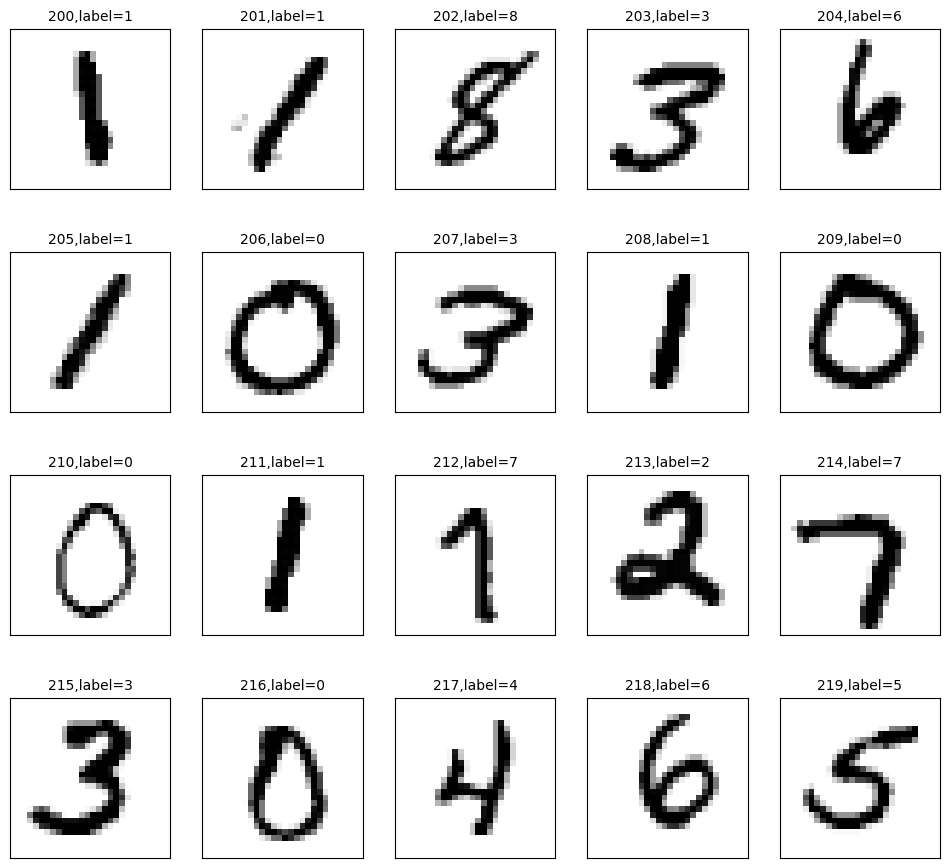

In [5]:
# 顯示訓練資料
show_imgs_labels_predict(x_train, y_train, [], 200, 20)

# 2. 訓練資料預處理

## 2-1. X_數據預處理

1. 將二維矩陣(28*28)轉成一維(784,)，image像素整數int轉成浮點數float
2. 標準化0~1浮點數 Normalization



In [6]:
# 數據預處理
# 1.將二維矩陣轉成一維，image像素整數int轉成浮點數float
x_train_new = x_train.reshape(60000, 28*28).astype('float32')
x_test_new = x_test.reshape(10000, 28*28).astype('float32')
print('x_train: %s' % (str(x_train_new.shape)))
print('x_test: %s' % (str(x_test_new.shape)))
x_train_new[0][150:160]

x_train: (60000, 784)
x_test: (10000, 784)


array([  0.,   0.,   3.,  18.,  18.,  18., 126., 136., 175.,  26.],
      dtype=float32)

In [7]:
# 數據預處理2.標準化0~1浮點數 Normalization
# 0~255 > 0~1
# x_train_norm
x_train_norm = x_train_new / 255
x_test_norm = x_test_new / 255
x_train_norm[0][150:160]

array([0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
       0.07058824, 0.49411765, 0.53333336, 0.6862745 , 0.10196079],
      dtype=float32)

## 2-2. Y_標籤碼 One-hot encoding
label 標籤 0-9 數字,，配合神經網路建模(輸出層尺寸)One-hot-encoding
數字轉換為 10 個 0 或 1 的編碼, 對應到輸出層的 10 個神經元

In [8]:
# One-Hot Encoding
y_train_onehot = np_utils.to_categorical(y_train)  #將 training 的 label 進行 one-hot encoding
y_test_onehot = np_utils.to_categorical(y_test) # 將測試的 labels 進行 one-hot encoding

print(y_train[0], y_train_onehot[:1])
# 檢視 training labels 第一個 label 的值 5
# 檢視第一個 label 在 one-hot encoding 後的結果

5 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


# 3. MLP分類建模與訓練

### 建立模型 多層感知模型MLP(Multilayer Perceptron)

輸入層 (x) 共有 28x28=784 個神經元

Hidden layers (h) 共有 256 神經元

輸出層 (y) 共有 10 個 神經元(分10類) One-hot encoding


In [9]:
# 建立模型
from tensorflow.keras.models import Sequential  # 序列模型工具
from tensorflow.keras.layers import Dense  # 全連接層

model = Sequential(name='MLP-mnist')
# 隱藏層 (神經元數量256,輸入尺寸28*28=784,權重的初始值,激活函數)
model.add(Dense(units=256, input_dim=784, kernel_initializer='normal', activation='relu'))  #relu 整流線性單元
# 輸出層
model.add(Dense(units=10, kernel_initializer='normal', activation='softmax'))
# softmax 離散概率分布的梯度對數歸一化(維基百科)

model.summary()

Model: "MLP-mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


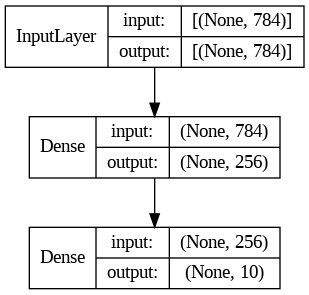

In [10]:
# 繪製模型圖
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, to_file='model.png')
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [11]:
# 模型參數計算
h1 = 784*256+256
h2 = 256*10+10
print(h1, h2, h1+h2)

200960 2570 203530


### compile 編譯模型
* loss函數: 交叉熵（Cross Entropy）模型預測值與真實值的差距大小
* optimizer: 優化器 adam 可以讓訓練更快收斂, 並提高準確率
* metrics: 設定評估模型的方式是 accuracy (準確率)


In [12]:
# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 訓練參數
* x=`x_train_norm`: features 數字的影像特徵值 (60,000 x 784 的陣列).
* y=`y_train_onehot`: label 數字的 One-hot encoding 陣列 (60,000 x 10 的陣列)
* `validation_split = 0.2`: 設定驗證資料比率. 也就是說會有 0.8 * 60,000 = 48,000 作為訓練資料; 0.2 * 60,000 = 12,000 作為驗證資料.
* `epochs = 10`: 執行 10 次的擬合.
* `batch_size = 200`: 每次的訓練數據筆數為 200
* `verbose = 2`: 顯示訓練過程.

### 執行訓練

In [13]:
# 訓練就是擬合 fit 的過程
# 每一訓練週期 epoch 會計算 accuracy 並記錄在 history
history = model.fit(x=x_train_norm, y=y_train_onehot, validation_split=0.2, epochs=10, batch_size=200, verbose=2)

Epoch 1/10
240/240 - 9s - loss: 0.4328 - accuracy: 0.8868 - val_loss: 0.2194 - val_accuracy: 0.9388 - 9s/epoch - 37ms/step
Epoch 2/10
240/240 - 3s - loss: 0.1896 - accuracy: 0.9457 - val_loss: 0.1567 - val_accuracy: 0.9574 - 3s/epoch - 11ms/step
Epoch 3/10
240/240 - 3s - loss: 0.1368 - accuracy: 0.9607 - val_loss: 0.1330 - val_accuracy: 0.9622 - 3s/epoch - 11ms/step
Epoch 4/10
240/240 - 3s - loss: 0.1063 - accuracy: 0.9697 - val_loss: 0.1119 - val_accuracy: 0.9686 - 3s/epoch - 13ms/step
Epoch 5/10
240/240 - 2s - loss: 0.0845 - accuracy: 0.9761 - val_loss: 0.1052 - val_accuracy: 0.9700 - 2s/epoch - 8ms/step
Epoch 6/10
240/240 - 2s - loss: 0.0693 - accuracy: 0.9808 - val_loss: 0.0941 - val_accuracy: 0.9737 - 2s/epoch - 8ms/step
Epoch 7/10
240/240 - 2s - loss: 0.0571 - accuracy: 0.9843 - val_loss: 0.0899 - val_accuracy: 0.9723 - 2s/epoch - 8ms/step
Epoch 8/10
240/240 - 2s - loss: 0.0476 - accuracy: 0.9872 - val_loss: 0.0837 - val_accuracy: 0.9743 - 2s/epoch - 8ms/step
Epoch 9/10
240/240 -

### 建立函數 show_history 顯示訓練過程



In [14]:
# 每一個訓練週期的 accuracy 與 loss 記錄在 history 變數
# 使用自訂函數讀取 history 以圖表顯示訓練過程
def show_history(history, train, validation):
    fig = plt.gcf()
    fig.set_size_inches(8,3)
    plt.plot(history.history[train])  #訓練過程
    plt.plot(history.history[validation])  #驗證過程
    plt.title('Training History')  #標題
    plt.ylabel(train)   #縱軸是 accuracy 與 loss 記錄
    plt.xlabel('Epoch')  #橫軸是訓練週期
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### 觀察分析訓練結果

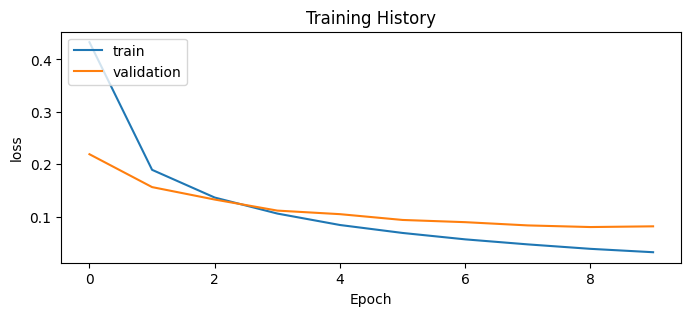

In [15]:
# 比較訓練 loss 與驗證 loss
show_history(history, 'loss', 'val_loss')

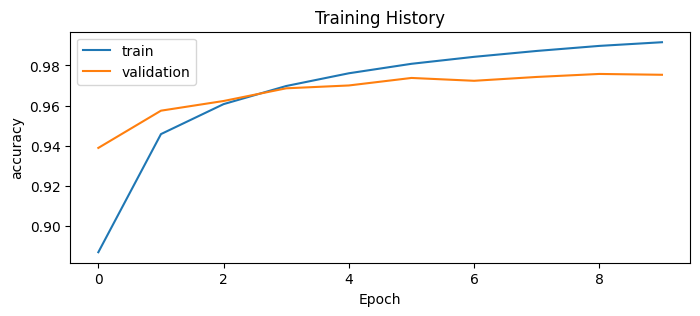

In [16]:
# 訓練有時發生欠擬合與過擬合 Overfitting
show_history(history, 'accuracy', 'val_accuracy')

如果`訓練的準確率acc` 有提升, 但是`驗證的準確率 val_acc`  卻一直沒有增加

就有可能是`過擬合 Overfitting` 的現象

# 4. 預測與分析

## 4-1. 預測
以`測試集`評估模型`準確率`與`預測分類`


In [17]:
# 評估模型 x_test_norm
scores = model.evaluate(x_test_norm, y_test_onehot)
print('測試集準確率 = {:2.1f}%'.format(scores[1]*100.0))

313/313 [==============================] - 1s 2ms/step - loss: 0.0732 - accuracy: 0.9777
測試集準確率 = 97.8%


## 4-2. 預測分類

In [18]:
# 預測分類 x_test_norm
# prediction = model.predict_classes(x_test_norm)

prediction_prob = model.predict(x_test_norm)
prediction = prediction_prob.argmax(axis = -1)

print(prediction[240:250]) # 顯示預測結果

313/313 [==============================] - 1s 2ms/step
[5 9 8 7 2 3 0 2 4 2]


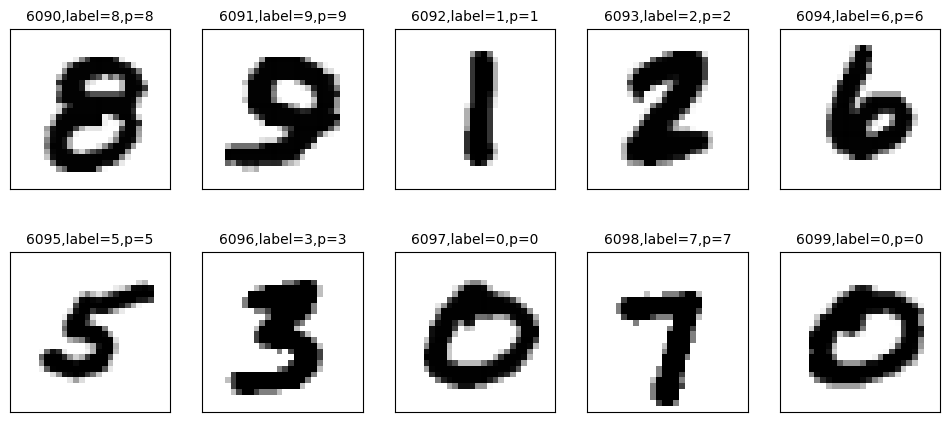

In [19]:
# 使用自訂函數顯示結果 (注意:241 245 247)
show_imgs_labels_predict(x_test, y_test, prediction, idx=6090)

## 4-3. 找出預測錯誤的圖片

In [20]:
#
no = 0
print('錯誤列表:')
for i in range(len(prediction)):
    if prediction[i] != y_test[i]:
        print('第 %d 筆標籤是: %d  ，錯誤預測成: %d' % (i, y_test[i], prediction[i]))
        no = no + 1
print(no)

# 簡單的寫法
print('正確數:', sum(prediction==y_test))
print('錯誤數:', sum(prediction!=y_test))
print('正確率:', (10000-no)/10000)

錯誤列表:
第 8 筆標籤是: 5  ，錯誤預測成: 6
第 247 筆標籤是: 4  ，錯誤預測成: 2
第 259 筆標籤是: 6  ，錯誤預測成: 0
第 320 筆標籤是: 9  ，錯誤預測成: 7
第 321 筆標籤是: 2  ，錯誤預測成: 7
第 340 筆標籤是: 5  ，錯誤預測成: 3
第 445 筆標籤是: 6  ，錯誤預測成: 0
第 495 筆標籤是: 8  ，錯誤預測成: 2
第 582 筆標籤是: 8  ，錯誤預測成: 2
第 583 筆標籤是: 2  ，錯誤預測成: 7
第 613 筆標籤是: 2  ，錯誤預測成: 8
第 619 筆標籤是: 1  ，錯誤預測成: 8
第 659 筆標籤是: 2  ，錯誤預測成: 1
第 684 筆標籤是: 7  ，錯誤預測成: 3
第 707 筆標籤是: 4  ，錯誤預測成: 9
第 720 筆標籤是: 5  ，錯誤預測成: 8
第 882 筆標籤是: 9  ，錯誤預測成: 7
第 951 筆標籤是: 5  ，錯誤預測成: 4
第 956 筆標籤是: 1  ，錯誤預測成: 2
第 965 筆標籤是: 6  ，錯誤預測成: 0
第 1003 筆標籤是: 5  ，錯誤預測成: 3
第 1014 筆標籤是: 6  ，錯誤預測成: 5
第 1032 筆標籤是: 5  ，錯誤預測成: 8
第 1039 筆標籤是: 7  ，錯誤預測成: 2
第 1107 筆標籤是: 9  ，錯誤預測成: 5
第 1112 筆標籤是: 4  ，錯誤預測成: 6
第 1178 筆標籤是: 4  ，錯誤預測成: 0
第 1182 筆標籤是: 6  ，錯誤預測成: 8
第 1226 筆標籤是: 7  ，錯誤預測成: 2
第 1232 筆標籤是: 9  ，錯誤預測成: 4
第 1242 筆標籤是: 4  ，錯誤預測成: 9
第 1247 筆標籤是: 9  ，錯誤預測成: 5
第 1299 筆標籤是: 5  ，錯誤預測成: 7
第 1319 筆標籤是: 8  ，錯誤預測成: 3
第 1378 筆標籤是: 5  ，錯誤預測成: 6
第 1393 筆標籤是: 5  ，錯誤預測成: 3
第 1395 筆標籤是: 2  ，錯誤預測成: 3
第 1500 筆標籤是: 7  ，錯誤預測成: 1
第 1522 筆標籤是: 7  ，錯誤預測成: 9
第 

## 4-4. 更多練習

In [21]:
# Homework
# H1. 修改參數 validation_split=0.5 或是其他數值 0.3, 0.1, 0.4...
# H2. 修改參數 batch_size=2000 或是其他數值 1000, 50,  ...
# 觀察 曲線圖結果有何不同? 訓練時間有何不同?

# 挑戰題
# 調整參數 可以讓測試集 241 245 247 預測正確嗎?

# 5. 模型儲存與使用

### `準確率`不是絕對的，會隨著`模型`、`參數`、`數據`而改變，同學每次`調整的模型`可以儲存起來，讓訓練完成的`模型`可以`供日後重複使用`，也`方便比較`不同模型`預測的結果`

## 5-1. 儲存模型

In [22]:
# 將模型完整儲存至HDF格式檔案
model.save('Mnist_mlp_model_v01.h5')

https://zh.wikipedia.org/wiki/HDF

In [23]:
# 刪除模型
del model

## 5-2. 載入已儲存模型

In [24]:
# 從檔案中載入模型
from tensorflow.keras.models import load_model
model = load_model('Mnist_mlp_model_v01.h5')
model.summary()

Model: "MLP-mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 1s 2ms/step
[5 9 8 7 2 3 0 2 4 2]


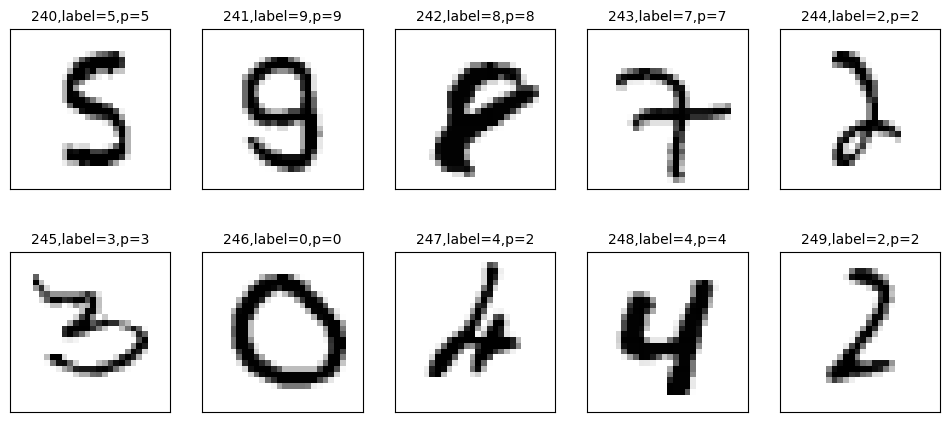

In [25]:
# 檢查預測結果
# prediction = model.predict_classes(x_test_norm)

prediction_prob = model.predict(x_test_norm)
prediction = prediction_prob.argmax(axis = -1)

print(prediction[240:250]) # 顯示預測結果
show_imgs_labels_predict(x_test, y_test, prediction, idx=240)
